In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd '/content/drive/MyDrive/Colab Notebooks/Image Style Transfer'

/content/drive/MyDrive/Colab Notebooks/Image Style Transfer


In [3]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=bc23f944d10e1162d2fcbdc697f66f0d50604e3b60cf8324af020444e1db65dc
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [4]:
import torch
import torch.nn as nn
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image
import warnings
warnings.filterwarnings('ignore')

### Things to check before diving in.

In [5]:
tensor = torch.tensor([1, 2, 3, 4])
print("Original Tensor:")
print(tensor)
# Unsqueeze the tensor along dimension 0
print(tensor.unsqueeze(0))

Original Tensor:
tensor([1, 2, 3, 4])
tensor([[1, 2, 3, 4]])


### Importing VGG19

In [6]:
model = models.vgg19(pretrained = True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:13<00:00, 42.9MB/s]



### `model.features`
##### ⦾ This refers to the convolutional layers and some pooling layers of the VGG-19 model. These layers are responsible for extracting hierarchical features from the input image. They are composed of convolutional blocks followed by max-pooling operations. The features part typically extracts useful patterns and features from the input images.

### `model.classfier`
##### ⦾ The classifier in VGG-19 is the fully connected layers that come after the convolutional layers. These layers are responsible for taking the high-level features extracted by the convolutional layers and converting them into class scores or probabilities. It essentially performs the classification task, mapping the extracted features to the output classes.

### `model.avgpool`
##### ⦾ This is the average pooling layer in the VGG-19 model. It is positioned between the convolutional layers and the fully connected classifier layers. The purpose of the average pooling layer is to reduce the spatial dimensions of the features obtained from the convolutional layers. It performs average pooling to condense the information while retaining the most important features.

In [7]:
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [8]:
model.features[0]

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

### To plot the architecture

In [ ]:
# import torch
# import torchvision.models as models
# from torchviz import make_dot

# model = models.vgg19(pretrained=True)

# dummy_input = torch.randn(1, 3, 224, 224)  # Assuming input size is 224x224x3

# output = model(dummy_input)

# dot = make_dot(output, params=dict(model.named_parameters()))
# dot.render("VGG19_architecture", format="png", cleanup=True)

'VGG19_architecture.png'

### Now according to the paper we need 1st layer of every block.
#### `conv2_1` mean 1 layer of 2nd block and so on.
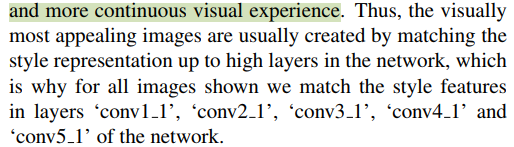

In [9]:
class CustomizedVgg19(nn.Module):
  def __init__(self):
    super().__init__()
    self.useful_features = ['0' , '5' , '10' , '19' , '28']
    # limiting vgg layers to only conv layers as we dont require FC layers acc. to the paper.
    self.model = models.vgg19(pretrained = True).features[:29]

  def forward(self,x):
    features = []

    for i,layer in enumerate(self.model):
      x = layer(x)

      if str(i) in self.useful_features:
        features.append(x)

    return features

In [25]:
transformation = transforms.Compose([transforms.Resize((1080,1080)),transforms.ToTensor()])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def image_loader(image):
  image = Image.open(image)
  image = transformation(image).unsqueeze(0) # adds dimension
  return image.to(device) # setting image to cuda or cpu to utilize gpu or cpu respectively

#### We can initialize the generated image to the white noise image or to the content image or to the style image.
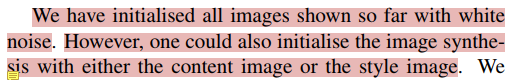

In [26]:
content_p = image_loader('sea.jpg') # content image
style_a = image_loader('old2.jpg') # style image | starry night by vincent gogh.png
generated_x = content_p.clone().requires_grad_(True) # this is the image, on which model will converge

In [27]:
model = CustomizedVgg19().to(device).eval()

In [28]:
optimizer = torch.optim.Adam([generated_x],lr = 0.1)
# optimizer = torch.optim.LBFGS([generated_x],lr = 0.034)
alpha = 1
beta = 0.01

In [29]:
epochs = 50
def closure():
    optimizer.zero_grad()
    generated_features = model(generated_x)
    content_features = model(content_p)
    style_features = model(style_a)

    content_loss = 0
    style_loss = 0

    for g_f, c_f, s_f in zip(generated_features, content_features, style_features):
        batch_size, channel, height, width = g_f.shape
        content_loss += torch.mean((g_f - c_f) ** 2)

        g = g_f.view(channel, height * width).mm(g_f.view(channel, height * width).t())
        s = s_f.view(channel, height * width).mm(s_f.view(channel, height * width).t())

        style_loss += torch.mean((g - s) ** 2)

    total_loss = alpha * content_loss + beta * style_loss
    total_loss.backward()
    return total_loss

for step in range(epochs):
    print(f'Epoch # {step}')
    optimizer.step(closure)
    if True:
        print(f'Loss: {closure().item()}')
        save_image(generated_x, '/content/drive/MyDrive/Colab Notebooks/Image Style Transfer/generated images/sea_effect_2.png')

Epoch # 0
Loss: 100667072.0
Epoch # 1
Loss: 106013104.0
Epoch # 2
Loss: 144490080.0
Epoch # 3
Loss: 117212920.0
Epoch # 4
Loss: 108411288.0
Epoch # 5
Loss: 99222992.0
Epoch # 6
Loss: 89562456.0
Epoch # 7
Loss: 81169968.0
Epoch # 8
Loss: 73743344.0
Epoch # 9
Loss: 66533496.0
Epoch # 10
Loss: 59582120.0
Epoch # 11
Loss: 53235392.0
Epoch # 12
Loss: 47452664.0
Epoch # 13
Loss: 42234148.0
Epoch # 14
Loss: 37586164.0
Epoch # 15
Loss: 33460332.0
Epoch # 16
Loss: 29765384.0
Epoch # 17
Loss: 26486278.0
Epoch # 18
Loss: 23575386.0
Epoch # 19
Loss: 21021550.0
Epoch # 20
Loss: 18774586.0
Epoch # 21
Loss: 16812036.0
Epoch # 22
Loss: 15070537.0
Epoch # 23
Loss: 13527559.0
Epoch # 24
Loss: 12152899.0
Epoch # 25
Loss: 10932818.0
Epoch # 26
Loss: 9852441.0
Epoch # 27
Loss: 8891605.0
Epoch # 28
Loss: 8032113.0
Epoch # 29
Loss: 7261531.5
Epoch # 30
Loss: 6572049.5
Epoch # 31
Loss: 5958804.5
Epoch # 32
Loss: 5411966.0
Epoch # 33
Loss: 4917474.0
Epoch # 34
Loss: 4474239.0
Epoch # 35
Loss: 4078226.25
Epoch 

In [ ]:
# epochs = 30
# def closure():
#     optimizer.zero_grad()
#     generated_features = model(generated_x)
#     content_features = model(content_p)
#     style_features = model(style_a)

#     content_loss = 0
#     style_loss = 0

#     for g_f, c_f, s_f in zip(generated_features, content_features, style_features):
#         batch_size, channel, height, width = g_f.shape
#         content_loss += torch.mean((g_f - c_f) ** 2)

#         g = g_f.view(channel, height * width).mm(g_f.view(channel, height * width).t())
#         s = s_f.view(channel, height * width).mm(s_f.view(channel, height * width).t())

#         style_loss += torch.mean((g - s) ** 2)

#     total_loss = alpha * content_loss + beta * style_loss
#     total_loss.backward()
#     return total_loss

# for step in range(epochs):
#     print(f'Epoch # {step}')
#     optimizer.step(closure)
#     if True:
#         print(f'Loss: {closure().item()}')
#         save_image(generated_x, '/content/drive/MyDrive/Colab Notebooks/Image Style Transfer/generated images/cat15.png')

In [ ]:
# epochs = 30

# print('before closure')
# def closure():
#     optimizer.zero_grad()
#     generated_features = model(generated_x)
#     content_features = model(content_p)
#     style_features = model(style_a)

#     content_loss = 0
#     style_loss = 0

#     for g_f, c_f, s_f in zip(generated_features, content_features, style_features):
#         batch_size, channel, height, width = g_f.shape
#         content_loss += torch.mean((g_f - c_f) ** 2)

#         g = g_f.view(channel, height * width).mm(g_f.view(channel, height * width).t())
#         s = s_f.view(channel, height * width).mm(s_f.view(channel, height * width).t())

#         style_loss += torch.mean((g - s) ** 2)

#     total_loss = alpha * content_loss + beta * style_loss
#     total_loss.backward()
#     return total_loss

# print('after closure')


# for i in range(59,76): # 59,76
#   print(f'W O R K I N G   O N   P I C T U R E  ###################### {i} ')
#   content_p = image_loader(f'/content/drive/MyDrive/Colab Notebooks/Image Style Transfer/cat/00{i}.jpg') # content image
#   style_a = image_loader('femme nue assise by picaso.jpg') # style image | starry night by vincent gogh.png
#   generated_x = content_p.clone().requires_grad_(True) # this is the image, on which model will converge
#   optimizer = torch.optim.LBFGS([generated_x],lr = 0.09)

#   for step in range(epochs):
#       print(f'Epoch # {step}')
#       optimizer.step(closure)
#       if True:
#           print(f'Loss: {closure().item()}')
#           save_image(generated_x, f'/content/drive/MyDrive/Colab Notebooks/Image Style Transfer/cat to art/00{i}.png')

In [ ]:
# epochs = 1000
# for step in range(epochs):
#   # model() will be returning the features by running the forward function
#   generated_features = model(generated_x)
#   content_features = model(content_p)
#   style_features = model(style_a)

#   content_loss = 0
#   style_loss = 0

#   for g_f,c_f,s_f in zip(generated_features,content_features,style_features):
#     batch_size,channel,height,width = g_f.shape
#     content_loss += torch.mean((g_f-c_f)**2)

#     # gram matrix , mm is matrix mulitply, we are changing the shape of the generated feature and mulitplying it
#     # the transpose of itself
#     g = g_f.view(channel,height*width).mm(g_f.view(channel,height*width).t())
#     s = s_f.view(channel,height*width).mm(s_f.view(channel,height*width).t())

#     style_loss += torch.mean((g-s)**2)

#   total_loss = alpha * content_loss + beta * style_loss
#   total_loss.backward()
#   optimizer.step()
#   optimizer.zero_grad()

#   if True:
#     print(f'Loss: {total_loss}')
#     save_image(generated_x,'/content/drive/MyDrive/Colab Notebooks/Image Style Transfer/generated images/bsh_picaso.png')